In [49]:
import deepSI
import numpy as np

class DuffingOscillator(deepSI.System_deriv):
    def __init__(self):
        super(DuffingOscillator, self).__init__(nx=2, dt=0.01)
        self.alpha = 1
        self.beta = 5
        self.gamma = 1
        self.delta = 1.5
        self.omega = 0.5

    def deriv(self,x,u):
        z1,z2 = x
        dz1 = self.gamma*u - self.delta*z1 - self.alpha*z2 - self.beta*(z2**3)
        dz2 = z1
        return [dz1,dz2]

    def h(self,x,u):
        #return x[1]
        return x + np.random.normal(0, 0.005, 2)

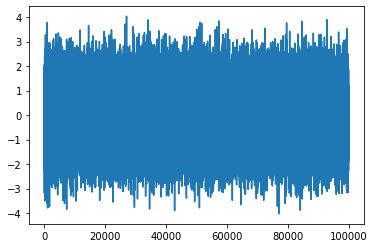

In [50]:
from matplotlib import pyplot as plt
u = deepSI.deepSI.exp_design.multisine(100000, pmax=40001, n_crest_factor_optim=20)
#u = deepSI.deepSI.exp_design.multisine(1000, pmax=401)
plt.plot(u)

In [51]:
sys_Duff = DuffingOscillator()

In [52]:
data = sys_Duff.apply_experiment(deepSI.System_data(u=u))

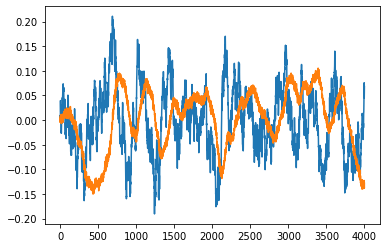

In [53]:
plt.plot(data.y[0:4000])

In [ ]:
from torch import nn
import torch
class stateSelector(nn.Module):
    def __init__(self): 
        super(stateSelector,self).__init__()

    def forward(self,x):
        return torch.mm(x, torch.tensor([[0.0],[1.0]], dtype=torch.float))

In [54]:
from torch import nn
class I_encoder(deepSI.fit_systems.SS_encoder):
    def __init__(self, nx = 2, na=2, nb=2, feedthrough=False) -> None:
        super().__init__(nx=nx, na=na, nb=nb, feedthrough=feedthrough)

    def init_nets(self, nu, ny): # a bit weird
        ny = ny if ny is not None else 1
        nu = nu if nu is not None else 1
        self.encoder = self.e_net(self.nb*nu+self.na*ny, self.nx, n_nodes_per_layer=self.e_n_nodes_per_layer, n_hidden_layers=self.e_n_hidden_layers, activation=self.e_activation)
        self.fn =      self.f_net(self.nx+nu,            self.nx, n_nodes_per_layer=self.f_n_nodes_per_layer, n_hidden_layers=self.f_n_hidden_layers, activation=self.f_activation)
        hn_in = self.nx + nu if self.feedthrough else self.nx
        #self.hn =      stateSelector()
        self.hn =      nn.Identity(hn_in)#self.h_net(hn_in     ,            ny,      n_nodes_per_layer=self.h_n_nodes_per_layer, n_hidden_layers=self.h_n_hidden_layers, activation=self.h_activation)

In [55]:
I_enc = I_encoder(nx=2, na=2, nb=2, feedthrough=False)
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

In [56]:
I_enc.fit(train_sys_data=train, val_sys_data=val, epochs=300, batch_size=256, loss_kwargs={'nf':150})

Initilizing the model and optimizer
Size of the training array =  208.2 MB
N_training_samples = 59849, batch_size = 256, N_batch_updates_per_epoch = 233
Initial Validation sim-NRMS= 1.251623872464017


  0%|          | 0/300 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.7546906466569964
Epoch    1, sqrt loss  0.8412, Val sim-NRMS 0.7547, Time Loss: 91.8%, data: 0.3%, val: 7.9%,  5.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.7524950168722748
Epoch    2, sqrt loss  0.7647, Val sim-NRMS 0.7525, Time Loss: 91.8%, data: 0.3%, val: 7.9%,  5.7 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.7226728403185918
Epoch    3, sqrt loss  0.7283, Val sim-NRMS 0.7227, Time Loss: 91.6%, data: 0.3%, val: 8.1%,  5.7 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.7196684322135394
Epoch    4, sqrt loss  0.7284, Val sim-NRMS 0.7197, Time Loss: 91.4%, data: 0.3%, val: 8.3%,  5.8 batches/sec
Epoch    5, sqrt loss  0.7516, Val sim-NRMS 0.7238, Time Loss: 91.3%, data: 0.3%, val: 8.4%,  5.9 batches/sec
Epoch    6, sqrt loss  0.7425, Val sim-NRMS 0.7469, Time Loss: 91.2%, data: 0.3%, val: 8.5%,  

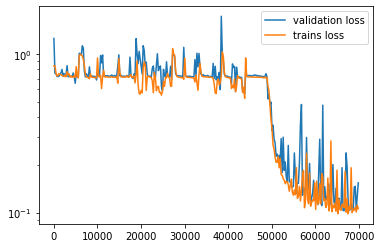

In [57]:
I_enc.checkpoint_load_system('_last')
plt.semilogy(I_enc.batch_id,I_enc.Loss_val,label='validation loss')
plt.semilogy(I_enc.batch_id,I_enc.Loss_train**0.5,label='trains loss')
plt.legend()

In [58]:
test_ss_enc = I_enc.apply_experiment(test,save_state=True)
#X = test_ss_enc.x

In [ ]:
# plt.subplot(2,4,1)
# plt.plot(test.y[:,0])
# plt.subplot(2,4,2)
# plt.plot(test_ss_enc.y[:,0])
# plt.subplot(2,4,3)
# plt.plot(X[:,0])

# plt.subplot(2,4,5)
# plt.plot(test.y[:,1])
# plt.subplot(2,4,6)
# plt.plot(test_ss_enc.y[:,1])
# plt.subplot(2,4,7)
# plt.plot(X[:,1])

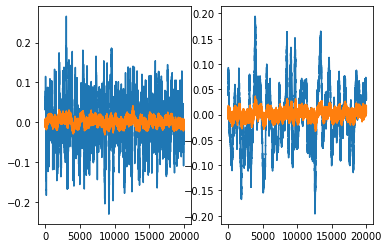

In [59]:
plt.subplot(1,2,1)
plt.plot(test.y[:,0])
plt.plot(test.y[:,0] - test_ss_enc.y[:,0])

plt.subplot(1,2,2)
plt.plot(test.y[:,1])
plt.plot(test.y[:,1] - test_ss_enc.y[:,1])

In [60]:
I_enc.save_system("systems/FullOutputSS_dt001_e600_Nstd0005")

In [ ]:
import deepSI
# first declare I_encoder above
#I_enc = deepSI.load_system("systems/FullOutputSS_dt01_e300")

In [61]:
# function that converts torch nn to casadi expression

from casadi import *

def CasADiFn(ss_enc, x, u):
    n_hidden_layers = ss_enc.f_n_hidden_layers
    nu = ss_enc.nu if ss_enc.nu is not None else 1

    params = {}
    for name, param in ss_enc.fn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())
    
    xu = vertcat(x,u)

    temp_nn = xu
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,xu) + b_Lin

    #f = Function('f', [x, u], [nn_NL + nn_Lin])
    return nn_NL + nn_Lin

In [62]:
# function that checks whether torch nn and casadi function have the same behavior

import torch

def checkCasADiFn(ss_enc, casadi_fn):
    nu = 1000
    u = (torch.rand(nu,3)*2-1)*2
    ss_out = ss_enc.fn(u).detach().numpy()

    check = True
    for i in range(nu):
        xin = u[i,0:2].numpy().tolist()
        uin = u[i,2].item()
        cas_out = f(xin, uin).elements()
        #equality_array = np.unique(np.round(np.array(cas_out) - ss_out[i,:], decimals=5) == 0.00000) #use np.isclose and np.all
        if np.allclose(np.array(cas_out), ss_out[i,:], rtol=1e-05, atol=1e-05) == False:
        #if equality_array.size != 1 or equality_array[0] == False:
            check = False

    return check

In [138]:
# declared sym variables
x = MX.sym("x",I_enc.nx,1)
nu = I_enc.nu if I_enc.nu is not None else 1
u = MX.sym("u",nu,1)

# convert torch nn to casadi function
rhs = CasADiFn(I_enc, x, u)
f = Function('f', [x, u], [rhs])

# check if torch nn and casadi function have same behavior
check = checkCasADiFn(I_enc, f)
check

True

In [139]:
# apply correction to casadi function such that fc(0) = 0
correction = f([0,0], 0)
rhs_c = rhs - correction
f_c = Function('f_c', [x, u], [rhs_c])
f_c([0,0], 0)

DM([0, 0])

In [140]:
# Box constraints
x_min = -50
x_max = 50
u_min = -20
u_max = 20

# Initial and final values
x0 = [0,0]
x0_normalized = x0#I_enc.norm.transform(deepSI.System_data(y=x0))
#x_ref = [0, 1.5]
u_ref = 0
u_ref_normalized = u_ref#I_enc.norm.transform(deepSI.System_data(u=u_ref))

# Weight matrices for the cost function
#Q = 100
Q = np.matrix('1,0;0,10')
R = 1

# MPC parameters
dt = 1/100
Nc = 2
Nsim = 50
dlam = 0.01
stages = 1

In [141]:
from my_rk4 import *
from lpv_int import *
from lpv_rk4 import *
import numpy as np
import time

opti = Opti()

# declare variables and parameters of states and inputs
n_states = np.shape(x)[0]
states = opti.variable(n_states,Nc+1)    
x_initial = opti.parameter(n_states,1)

n_controls = np.shape(u)[0]
controls = opti.variable(n_controls,Nc)

reference_normalized = opti.parameter(n_states,1)

# determine getA and getB functions
Jfx = Function("Jfx", [x, u], [jacobian(rhs_c,x)])
Jfu = Function("Jfu", [x, u], [jacobian(rhs_c,u)])
[A_sym, B_sym] = lpv_int(x,n_states,u,n_controls,Jfx,Jfu,dlam,stages)
get_A = Function("get_A",[x,u],[A_sym])
get_B = Function("get_B",[x,u],[B_sym])

list_A = opti.parameter(Nc*n_states,n_states)
list_B = opti.parameter(Nc*n_states,n_controls)

# declare bounds of system
#e = MX.sym("e",1,1)
#e = opti.variable()
#opti.subject_to(opti.bounded(x_min,states,x_max))
#opti.subject_to(opti.bounded(u_min,controls,u_max))
opti.subject_to(states[:,0] == x_initial)

opts = {'print_time' : 0, 'ipopt': {'print_level': 0}}
opti.solver("ipopt",opts)

In [142]:
# x1 = np.array([0,0])
# X1 = x1
# u1 = deepSI.deepSI.exp_design.multisine(100000, pmax=40001, n_crest_factor_optim=1)

# for ui in u1[:10]:
#     u_norm = I_enc.norm.transform(deepSI.System_data(u=ui)).u
#     A = get_A(x1,u_norm)
#     B = get_B(x1,u_norm)
#     x1 = A@x1 + B*ui
#     X1 = np.vstack((X1, x1.full().T))
    

In [143]:
# x2 = torch.tensor([0.0,0.0])
# X2 = x2.detach().numpy()

# for ui in u1[:10]:
#     u_norm = I_enc.norm.transform(deepSI.System_data(u=ui)).u
#     x2 = I_enc.fn(torch.concat((x2, torch.tensor([u_norm.item()]))).float())
#     X2 = np.vstack((X2, x2.detach().numpy()))

In [144]:
# plt.subplot(1,2,1)
# plt.plot(X1[:,0])
# # plt.plot(X2[:,0])
# plt.plot(X1[:,0] - X2[:,0])
# plt.subplot(1,2,2)
# plt.plot(X1[:,1])
# # plt.plot(X2[:,1])
# plt.plot(X1[:,1] - X2[:,1])

In [145]:
objective = 0 #maybe add some soft bounds on the states and inputs
for i in np.arange(Nc):
    #opti.subject_to(states[:,i+1] == lpv_rk4(states[:,i],controls[:,i],\
    #    list_A[(n_states*i):(n_states*i+n_states),:],list_B[(n_states*i):(n_states*i+n_states),:],dt, correction)) # should this be changed to discrete time model
    opti.subject_to(states[:,i+1] == list_A[(n_states*i):(n_states*i+n_states),:]@states[:,i] \
        + list_B[(n_states*i):(n_states*i+n_states),:]@controls[:,i] + correction)
    objective = (objective + 
                    #mtimes(mtimes((states[:,i]-x_ref).T,Q),(states[:,i]-x_ref)) +
                    #mtimes(mtimes((controls[:,i]-u_ref).T,R),(controls[:,i]-u_ref)))
                    mtimes(mtimes((states[:,i]-reference_normalized).T,Q),(states[:,i]-reference_normalized)) +
                    #mtimes(mtimes((controls[:,i]-u_ref_normalized.u.item()).T,R),(controls[:,i]-u_ref_normalized.u.item())))
                    mtimes(mtimes((controls[:,i]-u_ref_normalized).T,R),(controls[:,i]-u_ref_normalized)))

opti.minimize(objective)

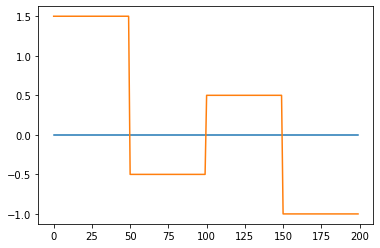

In [146]:
from matplotlib import pyplot as plt

#reference_list = np.ones(Nsim)*0.5
#reference_list = np.sin(np.arange(Nsim)*2*np.pi/82)*2.0
#reference_list = np.abs(np.sin(np.arange(Nsim)*2*np.pi/82)*1.0)
reference_list = np.vstack((np.zeros(200),\
    np.hstack((np.ones(50)*1.5, np.ones(50)*-0.5, np.ones(50)*0.5, np.ones(50)*-1.0))))
reference_list_normalized = reference_list#I_enc.norm.transform(deepSI.System_data(y=reference_list.T))
#plt.plot(reference_list_normalized.y)
plt.plot(reference_list_normalized[0,:])
plt.plot(reference_list_normalized[1,:])
#reference_list.T
#reference_list_normalized.y[100,:]

In [147]:
reference_list_normalized[:,2].tolist()

[0.0, 1.5]

In [148]:
# logging list
u_log = np.zeros([n_controls,Nsim])
t = np.zeros(Nsim)
t0 = 0
x_log = np.zeros([n_states,Nsim+1])
start = time.time()

# iteration values
lpv_counter = np.zeros(Nsim,int)

# set initial values for x
x = np.zeros([n_states,Nc+1]) # np.repeat(x0, NC+1)change this to x0 instead of 0
u = np.zeros([n_controls,Nc]) # change this to u0 instead of 0 maybe
opti.set_initial(states, x)
opti.set_initial(controls, u)
opti.set_value(x_initial,x0)
#x[:,0] = np.ravel(x0)

norm = I_enc.norm
max_iterations = 10

for mpciter in np.arange(Nsim):
    # determine A,B
    for i in np.arange(Nc):
        opti.set_value(list_A[(n_states*i):(n_states*i+n_states),:],get_A(x[:,i],u[:,i]))
        opti.set_value(list_B[(n_states*i):(n_states*i+n_states),:],get_B(x[:,i],u[:,i]))
    
    # solve for u and x
    #opti.set_value(reference_normalized,reference_list_normalized.y[mpciter,:].tolist())
    opti.set_value(reference_normalized,reference_list_normalized[:,mpciter].tolist())
    sol = opti.solve();
    u_old = u
    u = np.reshape(sol.value(controls),[n_controls,Nc])
    #for i in np.arange(Nc):
    #    x[:,i+1] = np.ravel(my_rk4(x[:,i],u[:,i],f,dt),order='F') # change this to f_c of f?
    x = np.reshape(sol.value(states),[n_states,Nc+1])
    opti.set_initial(states, x)
    opti.set_initial(controls, u)

    lpv_counter[mpciter] += 1

    while (lpv_counter[mpciter] < max_iterations) and (np.linalg.norm(u-u_old) > 1e-5):
        # determine A,B
        for i in np.arange(Nc):
            opti.set_value(list_A[(n_states*i):(n_states*i+n_states),:],get_A(x[:,i],u[:,i]))
            opti.set_value(list_B[(n_states*i):(n_states*i+n_states),:],get_B(x[:,i],u[:,i]))
        
        # solve for u and x
        sol = opti.solve()
        u_old = u
        u = np.reshape(sol.value(controls),[n_controls,Nc])

        # simulate next step using rk4 over non correction casadi function
        #for i in np.arange(Nc):
        #    x[:,i+1] = np.ravel(my_rk4(x[:,i],u[:,i],f,dt),order='F')
        x = np.reshape(sol.value(states),[n_states,Nc+1]) # change this to nn maybe
        
        # set new x and u values into optimizer
        opti.set_initial(states, x)
        opti.set_initial(controls, u)

        lpv_counter[mpciter] += 1  

    print("MPC iteration: ", mpciter+1)
    print("LPV counter: ", lpv_counter[mpciter])

    t[mpciter] = t0
    t0 = t0 + dt
    try:
        x = x.full()
    except:
        x = x
    try:
        u = u.full()
    except:
        u = u
    x_log[:,mpciter] = x[:,0]
    u_log[:,mpciter] = u[:,0]
    
    # denormalize x and u and run system step
    #x_denormalized = norm.inverse_transform(deepSI.System_data(y=x0)) # make sure
    x_denormalized = norm.ystd*x0 + norm.y0
    #u_denormalized = norm.inverse_transform(deepSI.System_data(u=u[0,0]))
    u_denormalized = norm.ustd*u[0,0] + norm.u0
    #x0 = x[:,1] # change this to real system step

    # normalize output of system step
    x_denormalized = sys_Duff.f(x_denormalized, u_denormalized)
    x0 = norm.transform(deepSI.System_data(y=x_denormalized))
    x0 = (x_denormalized - norm.y0)/norm.ystd

    x_log[:,mpciter+1] = x0
    
    #!!! add x shift and u shift for hot start
    x = horzcat(x[:,1:(Nc+1)],x[:,-1])
    x[:,0] = x0
    u = horzcat(u[:,1:Nc],u[:,-1])
    opti.set_value(x_initial, x0)
    opti.set_initial(states, x)
    opti.set_initial(controls, u)

end = time.time()
runtime = end - start

MPC iteration:  1
LPV counter:  3
MPC iteration:  2
LPV counter:  3
MPC iteration:  3
LPV counter:  3
MPC iteration:  4
LPV counter:  3
MPC iteration:  5
LPV counter:  3
MPC iteration:  6
LPV counter:  3
MPC iteration:  7
LPV counter:  3
MPC iteration:  8
LPV counter:  3
MPC iteration:  9
LPV counter:  3
MPC iteration:  10
LPV counter:  3
MPC iteration:  11
LPV counter:  3
MPC iteration:  12
LPV counter:  3
MPC iteration:  13
LPV counter:  3
MPC iteration:  14
LPV counter:  3
MPC iteration:  15
LPV counter:  3
MPC iteration:  16
LPV counter:  3
MPC iteration:  17
LPV counter:  3
MPC iteration:  18
LPV counter:  3
MPC iteration:  19
LPV counter:  3
MPC iteration:  20
LPV counter:  3
MPC iteration:  21
LPV counter:  3
MPC iteration:  22
LPV counter:  3
MPC iteration:  23
LPV counter:  3
MPC iteration:  24
LPV counter:  3
MPC iteration:  25
LPV counter:  3
MPC iteration:  26
LPV counter:  3
MPC iteration:  27
LPV counter:  3
MPC iteration:  28
LPV counter:  3
MPC iteration:  29
LPV counte

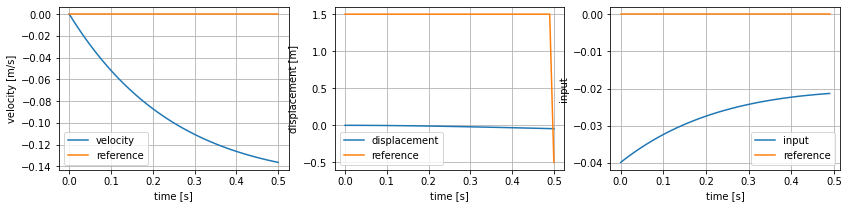

In [149]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=[14.0, 3.0])

plt.subplot(1,3,1)
plt.plot(np.arange(Nsim+1)*dt, x_log[0,:], label='velocity')
#plt.plot(np.arange(Nsim+1)*dt, np.ones(x_log.shape[1])*x_ref[0], label='reference')
plt.plot(np.arange(Nsim+1)*dt, reference_list[0,:51], label='reference')
plt.ylabel("velocity [m/s]") # not sure about the unit
plt.xlabel("time [s]")
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(Nsim+1)*dt, x_log[1,:], label='displacement')
#plt.plot(np.arange(Nsim+1)*dt, np.ones(x_log.shape[1])*x_ref[1], label='reference')
#plt.plot(np.arange(Nsim+1)*dt, np.hstack((np.zeros(1),reference_list)), label='reference') # figure out what the correct hstack should be here
plt.plot(np.arange(Nsim+1)*dt, reference_list[1,:51], label='reference')
plt.ylabel("displacement [m]") # not sure about the unit
plt.xlabel("time [s]")
plt.grid()
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(Nsim)*dt, u_log[0,:], label='input')
plt.plot(np.arange(Nsim)*dt, np.ones(Nsim)*u_ref, label='reference')
plt.ylabel("input") # not sure about the unit
plt.xlabel("time [s]")
plt.grid()
plt.legend();